In [8]:
# Imports

from datetime import datetime
import dateutil.parser
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from keras.layers import LeakyReLU

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6) # (w, h)
warnings.filterwarnings("ignore")

In [2]:
# load from file or request data to dataframe

# url = "http://10.109.168.75:9080/get_logs"

# resp = requests.get(url)
# json_data = json.loads(resp.text)

# df = pd.DataFrame(json_data)
columns = ['time', 'level', 'msg', 'container', 'pod', 'request', 'status', 'statuscode', 'type', 'url']
df = pd.read_csv("backup.csv", names=columns)
df = df.drop_duplicates()
print("There are total", len(df), "entries")
df.head()

There are total 1615 entries


,time,level,msg,container,pod,request,status,statuscode,type,url
0,2020-06-20T12:08:42Z,info,Liveness check performed,title,title-v1-6c9f679468-87cgh,GET,OK,200,liveness-check,http://172.17.0.6:8081
1,2020-06-20T12:09:12Z,info,Liveness check performed,title,title-v1-6c9f679468-87cgh,GET,OK,200,liveness-check,http://172.17.0.6:8081
2,2020-06-20T12:09:42Z,info,Liveness check performed,title,title-v1-6c9f679468-87cgh,GET,OK,200,liveness-check,http://172.17.0.6:8081
3,2020-06-20T12:10:12Z,info,Liveness check performed,title,title-v1-6c9f679468-87cgh,GET,OK,200,liveness-check,http://172.17.0.6:8081
4,2020-06-20T12:10:42Z,info,Liveness check performed,title,title-v1-6c9f679468-87cgh,GET,OK,200,liveness-check,http://172.17.0.6:8081


In [ ]:
# save to file

df.to_csv("data.csv", index=False)
print("Stored data to csv")

In [3]:
# pre-processing

def convert_to_datetime(timestr):
#     date_time_obj = datetime.strptime(timestr, "%Y-%m-%dT%H:%M:%S%Z")
    date_time_obj = dateutil.parser.parse(timestr)
    return date_time_obj

df['datetime'] = df.apply(lambda r: convert_to_datetime(r['time']), axis=1)
df = df.drop(columns='time')

df['statuscode'] = pd.to_numeric(df['statuscode'])
df.head()

,level,msg,container,pod,request,status,statuscode,type,url,datetime
0,info,Liveness check performed,title,title-v1-6c9f679468-87cgh,GET,OK,200,liveness-check,http://172.17.0.6:8081,2020-06-20 12:08:42+00:00
1,info,Liveness check performed,title,title-v1-6c9f679468-87cgh,GET,OK,200,liveness-check,http://172.17.0.6:8081,2020-06-20 12:09:12+00:00
2,info,Liveness check performed,title,title-v1-6c9f679468-87cgh,GET,OK,200,liveness-check,http://172.17.0.6:8081,2020-06-20 12:09:42+00:00
3,info,Liveness check performed,title,title-v1-6c9f679468-87cgh,GET,OK,200,liveness-check,http://172.17.0.6:8081,2020-06-20 12:10:12+00:00
4,info,Liveness check performed,title,title-v1-6c9f679468-87cgh,GET,OK,200,liveness-check,http://172.17.0.6:8081,2020-06-20 12:10:42+00:00


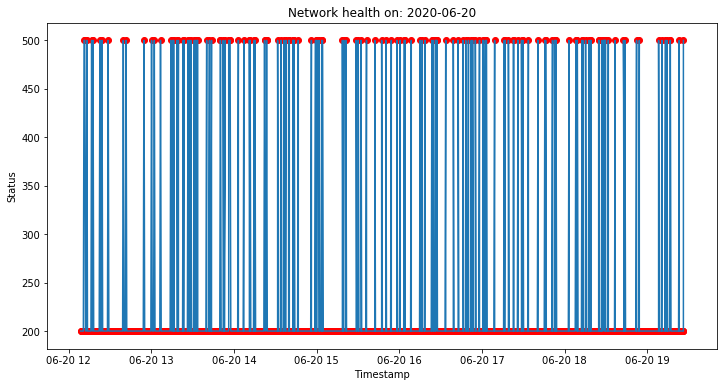

In [10]:
# plot for log data of all pods

for day in df['datetime'].dt.day.unique():
    data = df[df['datetime'].dt.day == day]
    plt.figure()
    plt.xlabel('Timestamp')
    plt.ylabel('Status')
    title = 'Network health on: ' + str(data['datetime'].dt.date.unique()[0])
    plt.title(title)
    plt.plot(data['datetime'], data['statuscode'])
    plt.scatter(data['datetime'], data['statuscode'], c='red')

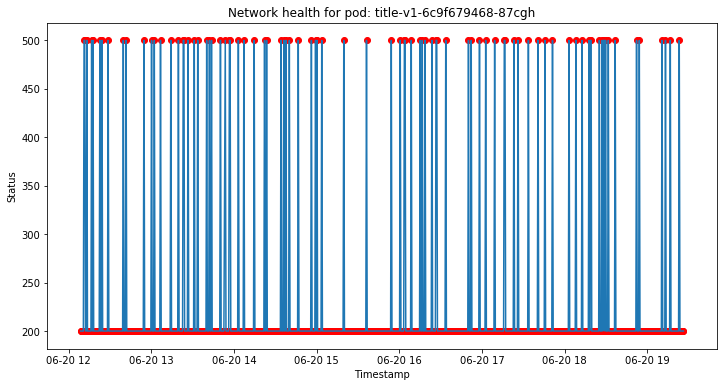

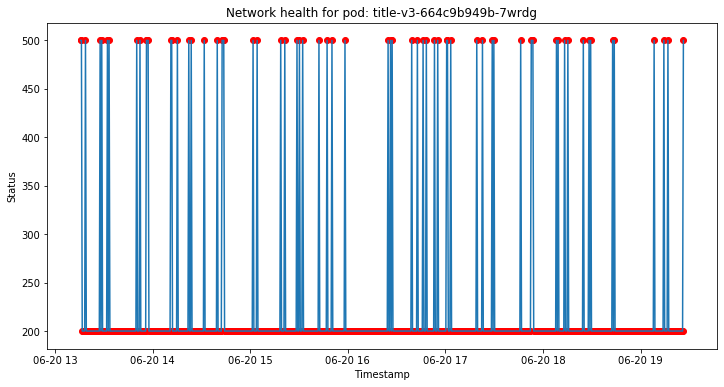

In [9]:
# plot for log data of each pod

for pod in df['pod'].unique():
    data = df[df['pod']==pod]
#     data = data[data['datetime'].dt.day == 19]
    
    
    plt.figure()
    plt.xlabel('Timestamp')
    plt.ylabel('Status')
    title = 'Network health for pod: ' + pod
    plt.title(title)
    plt.plot(data['datetime'], data['statuscode'])
    plt.scatter(data['datetime'], data['statuscode'], c='red')

In [ ]:
# df2 = df.copy()
# df2['statuscode'] = df2.apply(lambda r: 0 if r['statuscode'] >= 500 else 1, axis=1)

for pod in df['pod'].unique():
    data = df[df['pod']==pod]
#     data = data[data['datetime'].dt.day == 19]
    
    plt.figure()
    plt.xlabel('Timestamp')
    plt.ylabel('Status')
    title = 'Network health for pod: ' + pod
    plt.title(title)
    plt.plot(data['datetime'], data['statuscode'])

In [6]:
# prepare data for predicti

def prepare_data(data, split_size=0.7):
        
    data['day'] = data.apply(lambda r: r['datetime'].day, axis=1)
    data['hour'] = data.apply(lambda r: r['datetime'].hour, axis=1)
    data['minute'] = data.apply(lambda r: r['datetime'].minute, axis=1)
    data['second'] = data.apply(lambda r: r['datetime'].second, axis=1)
    
    x = data.as_matrix(columns=['day', 'hour', 'minute', 'second'])
    y = data['statuscode']
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = split_size)
    
    y_train, y_test = [0 if (n>=500) else 1 for n in  y_train], [0 if (n>=500) else 1 for n in  y_test]
     
    return x_train, x_test, y_train, y_test
    
def get_model():
    # define the keras model
    model = Sequential()
    model.add(Dense(8, input_dim=4, kernel_initializer='random_normal'))
#     model.add(LeakyReLU(alpha=0.3))
    model.add(Dense(12,kernel_initializer='random_normal'))
#     model.add(LeakyReLU(alpha=0.3))
    model.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
    
    return model

def oversample(x, y, duplicates=1):
    x_new = x
    y_new = y
    for i in range(len(y)):
        v = y[i]
        if v == 0:
            for j in range(duplicates):
                y_new = np.append(y_new, [0])
                x_new = np.append(x_new, [x[i]], axis=0)
                
    return x_new, y_new

Evaluating for pod: title-v1-6c9f679468-87cgh

699 699 627
915 915 627
Epoch 1/10
915/915 [==============================] - 1s 797us/step - loss: 0.6456 - acc: 0.6732
Epoch 2/10
915/915 [==============================] - 0s 101us/step - loss: 0.6261 - acc: 0.6852
Epoch 3/10
915/915 [==============================] - 0s 90us/step - loss: 0.6235 - acc: 0.6852
Epoch 4/10
915/915 [==============================] - 0s 99us/step - loss: 0.6239 - acc: 0.6852
Epoch 5/10
915/915 [==============================] - 0s 94us/step - loss: 0.6230 - acc: 0.6852
Epoch 6/10
915/915 [==============================] - 0s 93us/step - loss: 0.6225 - acc: 0.6852
Epoch 7/10
915/915 [==============================] - 0s 94us/step - loss: 0.6248 - acc: 0.6852
Epoch 8/10
915/915 [==============================] - 0s 95us/step - loss: 0.6245 - acc: 0.6852
Epoch 9/10
915/915 [==============================] - 0s 95us/step - loss: 0.6262 - acc: 0.6852
Epoch 10/10
915/915 [==============================] - 0s 95us/

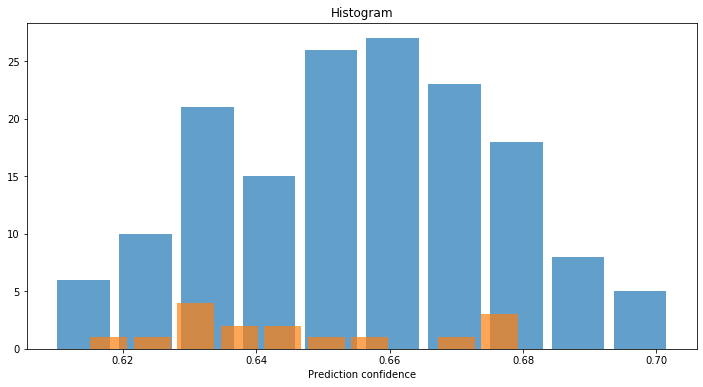

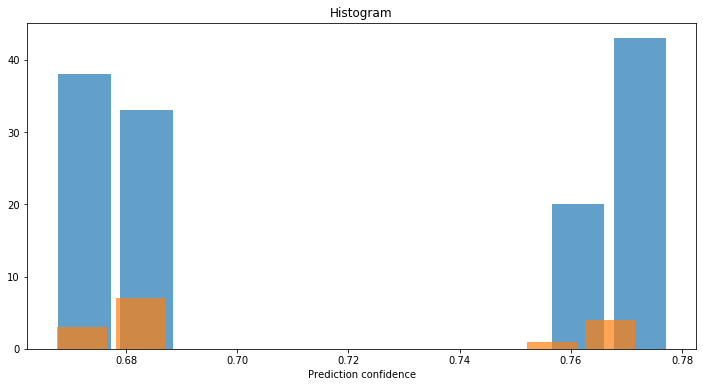

In [19]:
for pod in df['pod'].unique():
    print("Evaluating for pod: %s\n" % (pod) )
    data = df[df['pod']==pod]
#     data = data[data['datetime'].dt.day == 19]
    
    x_train, x_test, y_train, y_test = prepare_data(data, 0.8)
    
    print(len(x_train), len(y_train), sum(y_train))
    x_train, y_train = oversample(x_train, y_train, 3)
    print(len(x_train), len(y_train), sum(y_train))
    
    model = get_model()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=10, batch_size=10)
    
    _, accuracy = model.evaluate(x_train, y_train, verbose=0)
    print('Accuracy on train set: %.2f' % (accuracy*100))

    _, accuracy = model.evaluate(x_test, y_test, verbose=0)
    print('Accuracy on test set: %.2f' % (accuracy*100))
    
    pred = model.predict(x_test)
#     print(pred)
    
    pred_ok = []
    pred_err = []
    
    for i in range(len(pred)):
#         print("Prediction: %.3f, Actual: %d" % (pred[i], y_test[i]))
        if y_test[i] == 1:
            pred_ok.append(pred[i][0])
        else:
            pred_err.append(pred[i][0])

    plt.figure()
    plt.hist(pred_ok, bins=10, alpha=0.7, rwidth=0.85)
    plt.hist(pred_err, bins=10, alpha=0.7, rwidth=0.85)
    plt.xlabel('Prediction confidence')
    plt.title("Histogram")
    
    print("\n\n\n")